# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# just set the seed for the random number generator
np.random.seed(107)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Classes

In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader
%autoreload 1

In [4]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()

In [5]:
def read_pair(leg1, leg2, data_source, initial_date, final_date, close_type='Adj Close'):
    
    leg1_df = data.DataReader(leg1, data_source, initial_date, final_date)
    leg2_df = data.DataReader(leg2, data_source, initial_date, final_date)
    
    # filter columns of interest
    leg1_name = leg1 + "_close"
    leg2_name = leg2 + "_close"
    leg1_df = leg1_df[[close_type]].rename(columns={close_type: leg1_name})
    leg2_df = leg2_df[[close_type]].rename(columns={close_type: leg2_name})
    
    # concat in df
    pair_df = pd.concat([leg1_df, leg2_df], axis=1)
    
    # plot
    pair_df.plot(figsize=(20, 10), use_index=True, grid=True);
    
    return pair_df

# 3. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [6]:
etfs = pd.read_excel('data/etfs/commodity_ETFs.xlsx')

In [7]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


Remove duplicates

In [8]:
etfs_unique = etfs[~etfs.duplicated(subset=['Ticker'], keep='first')].sort_values(['Ticker'])

In [9]:
tickers = etfs_unique.Ticker.unique()

In [10]:
initial_date = '01-01-2014'
final_date = '01-01-2015'
data_source = 'yahoo'
error_counter = 0
dataset = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        df = df[['Adj Close']].rename(columns={'Adj Close':ticker}) # filter close price only
        dataset[ticker] = df.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for '+ticker)

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for AMJL
Not Possible to retrieve information for AMUB
Not Possible to retrieve information for AOIL
Not Possible to retrieve information for BAR
Not Possible to retrieve information for BATT
Not Possible to retrieve information for BCD
Not Possible to retrieve information for BCI
Not Possible to retrieve information for BMLP
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for COMB
Not Possible to retrieve information for COMG
Not Possible to retrieve information for CRAK
Not Possible to retrieve information for DRIP
Not Possible to retrieve information for DWT
Not Possible to retrieve information for FTXN
Not Possible to retrieve information for GASX
Not Possible to retrieve information for GDXS
Not Possible to retrieve information for GDXX
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for GLDW
Not Possible to retrieve information f

In [11]:
print('Unable to download ' + str(error_counter/len(tickers)*100) + '% of the ETFs')
print('From now on, we are only considering ' + str(len(tickers)-error_counter) + ' ETFs')

Unable to download 22.58064516129032% of the ETFs
From now on, we are only considering 168 ETFs


## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [12]:
first_count = True
for k in dataset.keys():
    if dataset[k] is not None:
        if first_count:
            etfs_pricing = dataset[k]
            first_count = False
        else:
            etfs_pricing = pd.concat([etfs_pricing, dataset[k]], axis=1)
            
print(etfs_pricing.shape)

(252, 168)


**Remove ETFs without sufficient information**

In [13]:
null_values = etfs_pricing.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AMZA    189
OUNZ     93
PDBC    215
SGDM    133
ZMLP     15
dtype: int64

In [14]:
threshold = 0
to_remove = list(null_values[null_values>threshold].index)
etfs_pricing = etfs_pricing.drop(columns=to_remove)
print(etfs_pricing.shape)

(252, 163)


In [15]:
etfs_returns = etfs_pricing.pct_change()
etfs_returns = etfs_returns.iloc[1:]
etfs_returns.head()

,AGF,AGQ,AMJ,AMLP,AMU,ATMP,BAL,BCM,BDD,BNO,...,USV,VDE,WEAT,XES,XLE,XME,XOP,YMLI,YMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.000000,0.021110,-0.001530,-0.001702,-0.000347,-0.002221,-0.014124,-0.009891,-0.017751,-0.007280,...,0.010941,-0.002407,0.004084,0.002092,-0.003667,-0.009379,-0.009090,-0.001917,0.002184,-0.022243
2014-01-06,-0.016614,0.000000,-0.001313,-0.001706,0.001388,-0.002597,0.003629,0.000512,-0.002410,0.002602,...,-0.005050,-0.000241,0.008814,-0.004872,0.001381,-0.007574,-0.005414,-0.001921,0.000000,0.000958
2014-01-07,0.028962,-0.031305,0.001534,0.000570,-0.001733,0.001488,0.010088,-0.001536,-0.002415,0.001416,...,-0.014866,0.007804,-0.008065,-0.003031,0.007581,-0.007393,0.009223,0.000481,0.001089,0.032177
2014-01-08,-0.007037,-0.030488,-0.008095,-0.007399,-0.008330,-0.007429,-0.016582,-0.008205,0.004843,-0.001414,...,-0.023923,-0.006467,-0.017615,-0.011459,-0.006955,-0.007208,-0.004494,-0.003848,0.000000,0.031174
2014-01-09,0.000000,0.000000,0.000662,0.000000,0.000700,0.000374,-0.001724,-0.004654,-0.048193,-0.008259,...,0.013575,-0.003455,0.006897,-0.004022,-0.003100,-0.016699,-0.004063,-0.002897,0.000544,-0.001911


In [16]:
print('Total number of possible pairs: ', len(etfs_returns.columns)*(len(etfs_returns.columns)-1)/2)

Total number of possible pairs:  13203.0


**Applying PCA on Returns**

In [17]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(etfs_returns)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
pca.components_.T.shape

(163, 50)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. 

In [19]:
X = preprocessing.StandardScaler().fit_transform(pca.components_.T)
print(X.shape)

(163, 50)


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [20]:
clf = DBSCAN(eps=2, min_samples=2)
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

Clusters discovered: 9


In [21]:
clustered_series = pd.Series(index=etfs_returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [22]:
counts = clustered_series.value_counts()
print("Clusters formed: %d" % len(counts))
print("Pairs to evaluate: %d" % (counts*(counts-1)/2).sum())

Clusters formed: 9
Pairs to evaluate: 289


In [23]:
print(counts)

1    17
6    11
0    10
3     9
8     4
4     4
5     3
7     2
2     2
dtype: int64


**Fundamental analysis for clusters**

In [24]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))
    #print('\nCluster {}:\n{}'.format(label_n,etfs_cluster_n.Segment.value_counts()))


Cluster 0:
    Ticker            Segment
156    AMJ  Equity: U.S. MLPs
154   AMLP  Equity: U.S. MLPs
170    AMU  Equity: U.S. MLPs
157   EMLP  Equity: U.S. MLPs
181   ENFR  Equity: U.S. MLPs
161   MLPA  Equity: U.S. MLPs
178   MLPC  Equity: U.S. MLPs
159   MLPI  Equity: U.S. MLPs
164   MLPX  Equity: U.S. MLPs
200   YMLI  Equity: U.S. MLPs

Cluster 1:
    Ticker                        Segment
72     BCM      Commodities: Broad Market
62     BNO  Commodities: Energy Crude Oil
28     DBC      Commodities: Broad Market
61     DBE            Commodities: Energy
43     DBO  Commodities: Energy Crude Oil
32     DJP      Commodities: Broad Market
50    FTGC      Commodities: Broad Market
53     GCC      Commodities: Broad Market
148    GSC      Commodities: Broad Market
30     GSG      Commodities: Broad Market
79     GSP      Commodities: Broad Market
60     OIL  Commodities: Energy Crude Oil
145    RJI      Commodities: Broad Market
146    RJN            Commodities: Energy
37    USCI      

Comparing results obtaned with most obvious scenario:

In [25]:
grouped = etfs_unique.groupby(by='Segment').count()[['Ticker']]
grouped[grouped.Ticker > 1]

,Ticker
Segment,
Commodities: Agriculture,7
Commodities: Agriculture Grains,3
Commodities: Agriculture Sugar,2
Commodities: Broad Market,21
Commodities: Energy,4
Commodities: Energy Crude Oil,10
Commodities: Energy Natural Gas,3
Commodities: Industrial Metals,2
Commodities: Industrial Metals Copper,2


What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

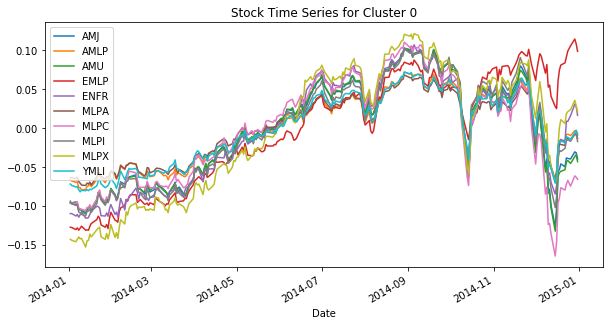

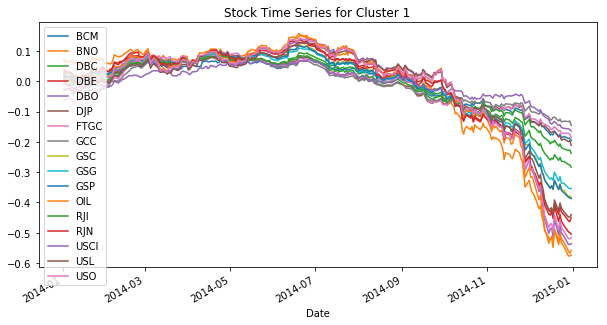

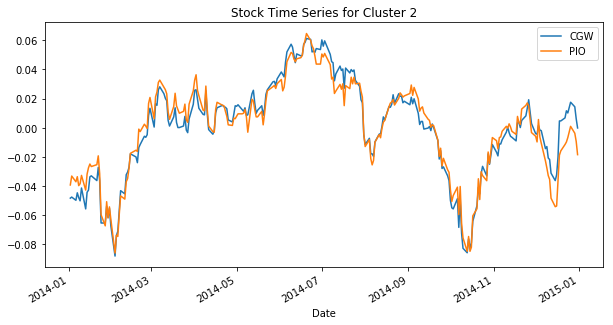

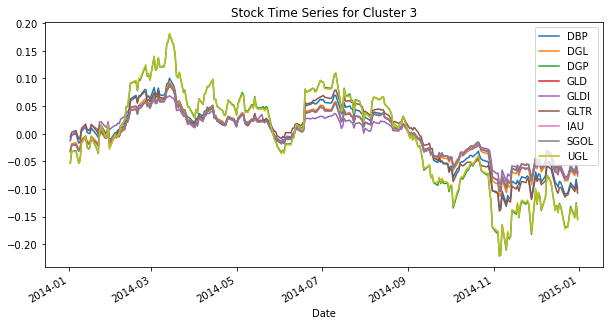

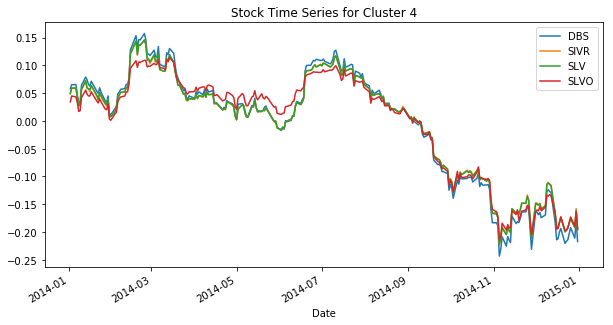

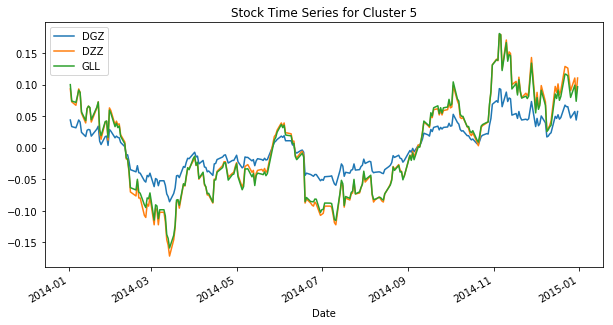

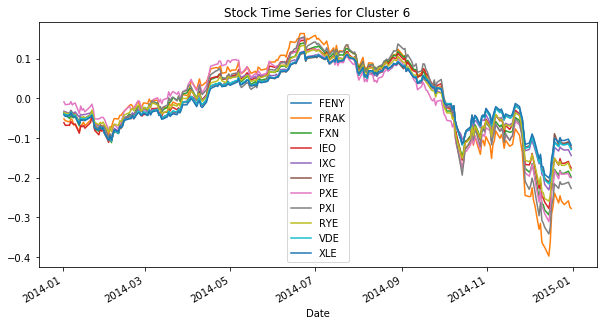

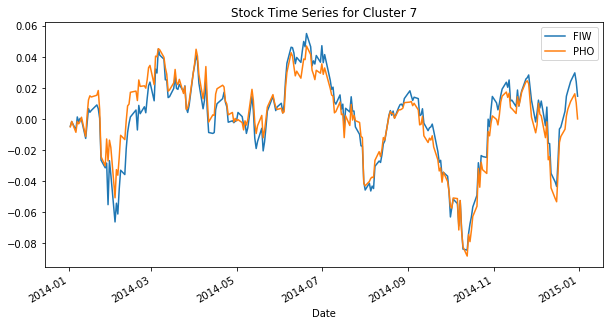

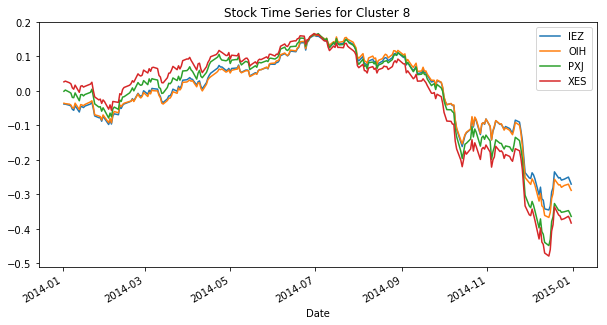

In [26]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(etfs_pricing[symbols].mean())
    series = np.log(etfs_pricing[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [27]:
total_pairs = []
threshold = 0.05
pairs_found = 0
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    cluster_pricing = etfs_pricing[symbols]
    pairs = series_analyzer.find_cointegrated_pairs(cluster_pricing, threshold, 5)
    total_pairs.extend(pairs)
    #print('\nCluster {}: {}'.format(clust,[(pair[0], pair[1], pair[2]['p_value']) for pair in pairs]))
    pairs_found += len(pairs)
print('Found {} pairs'.format(pairs_found))

Found 26 pairs


In [28]:
print('The pairs contain {} unique tickers'.format(
        len(np.unique([(element[0], element[1]) for element in total_pairs]))))

The pairs contain 26 unique tickers


**Applying Bollinger Bands**

In [29]:
lookback_multiplier=2
sharpe_results_bollinger = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    #print('Cointegration coefficient: ',coint_result['coint_coef'])
    hl = series_analyzer.calculate_half_life(coint_result['spread'])
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(coint_result['Y'], coint_result['X'], 
                                                               lookback_multiplier*int(round(hl)))
    sharpe_results_bollinger.append(sharpe)



AMLP,ENFR
APR -0.045597126731673376
Sharpe -1.5129856997166937


AMLP,MLPX
APR 0.002285446228286414
Sharpe 0.09280024630686796


MLPX,YMLI
APR -0.034179092460412175
Sharpe -1.0508958726191966


BCM,FTGC
APR 0.037539462927793865
Sharpe 0.9494125569678856


DBE,OIL
APR 0.015989889143277036
Sharpe 0.5180045099628082


DBO,USL
APR 0.014341942614269909
Sharpe 0.9615771214685545


DJP,FTGC
APR -0.0068961946333138124
Sharpe -0.2875893347190475


FTGC,GCC
APR 0.008726596842440815
Sharpe 0.4005356828585475


FTGC,RJI
APR 0.010632129701588333
Sharpe 0.3839186647888579


DBP,DGL
APR -0.009010481286245375
Sharpe -0.784956867432349


DBP,DGP
APR 0.0014925261090454889
Sharpe 0.11899886320112131


DBP,GLD
APR -0.006399423677630023
Sharpe -0.5715723840010519


DBP,IAU
APR -0.003990585460132312
Sharpe -0.3370420704295029


DBP,SGOL
APR -0.003938100140220779
Sharpe -0.34519152317941604


DBP,UGL
APR -0.017739344505139143
Sharpe -1.0981579181236285


DGL,GLTR
APR 0.023131302095674267
Sharpe 1.166794331

**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  0.1428431139679333


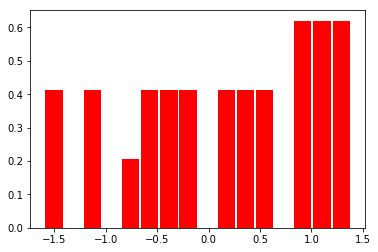

In [30]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

**Applying the Kalman filter based strategy**

In [31]:
sharpe_results_kalman = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, sharpe = trader.kalman_filter(y=coint_result['Y'], x=coint_result['X'])
    sharpe_results_kalman.append(sharpe)



AMLP,ENFR
APR 0.0020820713381954903
Sharpe 1.0452895814153769


AMLP,MLPX
APR 0.010260862544203553
Sharpe 0.8064259130291728


MLPX,YMLI
APR 0.048470793235989795
Sharpe 2.921065530391016


BCM,FTGC
APR 0.008277800201982544
Sharpe 0.9189938764026845


DBE,OIL
APR 0.034730975017495114
Sharpe 1.0981627930346491


DBO,USL
APR 0.03471765123564641
Sharpe 2.07456114532054


DJP,FTGC
APR 0.0027395079594594307
Sharpe 0.3502016691865887


FTGC,GCC
APR 0.010098931852311699
Sharpe 1.217686196085145


FTGC,RJI
APR 0.038625435247208406
Sharpe 1.5090268000038332


DBP,DGL
APR -0.010208386213160447
Sharpe -0.9527319026550918


DBP,DGP
APR 0.03804456691363933
Sharpe 1.137481568109333


DBP,GLD
APR -0.008628847327908917
Sharpe -0.6479682862125042


DBP,IAU
APR -0.00947859023425035
Sharpe -0.8581614785866853


DBP,SGOL
APR -0.00982318432160123
Sharpe -0.6750266378837884


DBP,UGL
APR 0.09269322531904844
Sharpe 2.2467493984171902


DGL,GLTR
APR -0.010070915057763252
Sharpe -0.9390475230321574


DGP,GLTR

**Kalman Filter Performance**

Sharpe Ratio Results: 
Average result:  0.4957385457660613


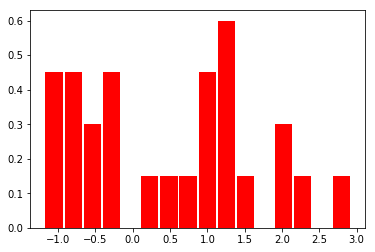

In [32]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))